In [22]:
import os
import json
from datetime import datetime
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import models
from torchvision.models import vit_b_16, vit_b_32
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

import seaborn as sns
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
simple_load = v2.Compose([
    v2.Resize((224, 224)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
])

In [4]:
data_8cls_base_path = 'data/processed8'
data_2cls_base_path = 'data/processed2'
# data_8cls_base_path = 'data/subset'
# data_2cls_base_path = 'data/subset'

In [5]:
train_dataset_8cls = ImageFolder(f'{data_8cls_base_path}/train/known', transform=simple_load)
test_dataset_8cls = ImageFolder(f'{data_8cls_base_path}/test/known', transform=simple_load)
val_dataset_8cls = ImageFolder(f'{data_8cls_base_path}/valid/known', transform=simple_load)

train_dataset_2cls = ImageFolder(f'{data_2cls_base_path}/train/known', transform=simple_load)
test_dataset_2cls = ImageFolder(f'{data_2cls_base_path}/test/known', transform=simple_load)
val_dataset_2cls = ImageFolder(f'{data_2cls_base_path}/valid/known', transform=simple_load)

In [6]:
def get_image(path: str):
    image = torchvision.io.read_image(path)
    return v2.ToPILImage()(image)


def get_image_resized(path: str):
    image = get_image(path)
    # Resize required for ViT to work. It is done for all models for a fair comparison
    resize = v2.Resize((224, 224))
    bigger_image = resize(image)

    return v2.ToPILImage()(bigger_image)

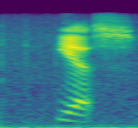

In [7]:
path = f'./{data_8cls_base_path}/train/known/yes/004ae714_nohash_0.png'
get_image(path)

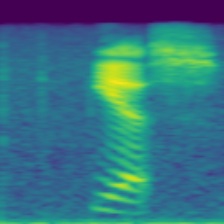

In [8]:
get_image_resized(path)

## Models

CNN Model Resnet-18 not pretrained (random weights)

In [9]:
def get_resnet(n_classes: int):
    model_resnet = models.resnet18(pretrained=False)

    output_features = model_resnet.fc.in_features 
    ## We have 512 output features, we have to add to model a fully connected layer for our 
    ## classification problem with only specified target classes
    model_resnet.fc = nn.Linear(output_features, n_classes)
    model_resnet = model_resnet.to(device)
    return model_resnet

Custom CRNN

In [10]:
class CustomCRNN(nn.Module):

    def __init__(self, n_classes: int):
        super(CustomCRNN, self).__init__()

        conv_channels = (64, 128, 256, 512)

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=conv_channels[0], kernel_size=6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=conv_channels[0], out_channels=conv_channels[1], kernel_size=6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=conv_channels[1], out_channels=conv_channels[2], kernel_size=6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=conv_channels[2], out_channels=conv_channels[3], kernel_size=6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.flatten = nn.Flatten()
        self.rnn = nn.LSTM(input_size=conv_channels[3] * 9 * 9, hidden_size=256)
        self.fc = nn.Sequential(
            nn.Linear(256, n_classes),
            nn.Softmax(dim=1),
        )
        self.to(device)

    def forward(self, obs) -> torch.Tensor:
        out_conv = self.conv(obs)
        out_conv_flat = self.flatten(out_conv)
        out_rnn = self.rnn(out_conv_flat)[0]
        out_proba = self.fc(out_rnn)
        return out_proba

Transformer VIT-base-16

In [23]:
def get_vit_base():
    vit_base = vit_b_16()
    vit_base.to(device)
    return vit_base

## Train function

In [12]:
def train(network: nn.Module, train_dataset: ImageFolder, valid_dataset: ImageFolder, batch_size: int,
          loss_fn, optimizer: torch.optim.Optimizer, max_epochs: int, cooldown_min=0,
          save_name: str | None = None, verbosity_period=1) -> dict[str, list[float]]:
    """
    Based on: https://alirezasamar.com/blog/2023/03/fine-tuning-pre-trained-resnet-18-model-image-classification-pytorch/

    Returns:
        training statstics
    """
    train_loss_per_epoch: list[float] = []
    train_accuracy_per_epoch: list[float] = []
    valid_loss_per_epoch: list[float] = []
    valid_accuracy_per_epoch: list[float] = []

    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(max_epochs):
        epoch = epoch + 1

        # setup for training
        network.train()
        train_epoch_loss_sum = 0.0
        train_epoch_true_count = 0

        # training loop
        for images, true_labels in train_data_loader:

            # move to the device (especially necessary when using cuda)
            images = images.to(device)
            true_labels = true_labels.to(device)

            # feed forward
            optimizer.zero_grad()
            pred_proba = network(images)

            loss = loss_fn(pred_proba, true_labels)
            # backpropagation and update weights
            loss.backward()
            optimizer.step()

            # update current epoch's stats
            train_epoch_loss_sum += loss.item() * images.size(0)
            # calculate accuracy but only if no advanced augmentations are used
            # this is because with advanced augmentations true_labels becomes
            # probabilites of each class
            pred_labels = torch.argmax(pred_proba, dim=1)
            train_epoch_true_count += torch.sum(pred_labels == true_labels.data)

        # calculate and update stats
        curr_train_loss = float(train_epoch_loss_sum / len(train_dataset))
        curr_train_accuracy = float(train_epoch_true_count.double() / len(train_dataset))
        train_loss_per_epoch.append(curr_train_loss)
        train_accuracy_per_epoch.append(curr_train_accuracy)

        # setup for validation
        network.eval()
        valid_epoch_loss_sum = 0.0
        valid_epoch_true_count = 0

        with torch.no_grad():
            # same as before but on validation data
            for images, true_labels in valid_data_loader:
                # move to device
                images = images.to(device)
                true_labels = true_labels.to(device)

                # make a prediction
                pred_proba = network(images)
                pred_labels = torch.argmax(pred_proba, dim=1)
                loss = loss_fn(pred_proba, true_labels)

                # update stats
                valid_epoch_loss_sum += loss.item() * images.size(0)
                valid_epoch_true_count += torch.sum(pred_labels == true_labels.data)

        # calculate and update stats
        curr_valid_loss = float(valid_epoch_loss_sum / len(valid_dataset))
        curr_valid_acccuracy = float(valid_epoch_true_count.double() / len(valid_dataset))
        valid_loss_per_epoch.append(curr_valid_loss)
        valid_accuracy_per_epoch.append(curr_valid_acccuracy)

        # Verbosity
        if verbosity_period > 0 and epoch % verbosity_period == 0:
            train_acc_text = ''
            train_acc_text = f'Train accuracy: {curr_train_accuracy:.4f} | '
            print(f'Epoch {epoch} completed! | '
                  f'Train loss: {curr_train_loss:.4f} | '
                  f'{train_acc_text}'
                  f'Validation loss: {curr_valid_loss:.4f} | '
                  f'Validation accuracy: {curr_valid_acccuracy:.4f}')
            
        # Cooldown
        if cooldown_min > 0:
            time.sleep(cooldown_min * 60)

    stats = {
        'train_loss': train_loss_per_epoch,
        'train_accuracy': train_accuracy_per_epoch,
        'valid_loss': valid_loss_per_epoch,
        'valid_accuracy': valid_accuracy_per_epoch,
    }

    # save network weights and stats at the end
    if save_name is not None:
        # prepare save dir
        datetime_id = datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
        save_dir = os.path.join('.', 'saved', f'{save_name}_{datetime_id}')
        os.makedirs(save_dir, exist_ok=True)
        # save network weights
        model_path = os.path.join(save_dir, f'{save_name}.pth')
        torch.save(network.state_dict(), model_path)
        # save training stats
        stats_path = os.path.join(save_dir, f'{save_name}.json')
        with open(stats_path, 'w') as file:
            json.dump(stats, file)
    
    return stats

In [13]:
def load_weights(network_fresh: nn.Module, path: str) -> None:
    """Loads saved weights to the given network"""
    network_fresh.load_state_dict(torch.load(path, map_location=torch.device(device)))
    network_fresh.eval()

In [14]:
def load_stats(path: str) -> dict[str, list[float]]:
    with open(path) as file:
        stats = json.load(file)
    return stats

# Train models

### Train Resnet-18 not pretrained

In [ ]:
torch.manual_seed(28)
torch.cuda.manual_seed(28)

model_resnet = get_resnet(8)

# 23 min (15 epochs)
stats_resnet = train(
    model_resnet, train_dataset_8cls, val_dataset_8cls, 
    batch_size=64, 
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optim.Adam(model_resnet.parameters(), lr=0.001), 
    max_epochs=15,
    save_name='architectures_resnet',
)

Epoch 1 completed! | Train loss: 0.3840 | Train accuracy: 0.8734 | Validation loss: 0.4995 | Validation accuracy: 0.8291
Epoch 2 completed! | Train loss: 0.1499 | Train accuracy: 0.9500 | Validation loss: 0.7387 | Validation accuracy: 0.7663
Epoch 3 completed! | Train loss: 0.1105 | Train accuracy: 0.9623 | Validation loss: 0.2115 | Validation accuracy: 0.9300
Epoch 4 completed! | Train loss: 0.1065 | Train accuracy: 0.9653 | Validation loss: 0.1918 | Validation accuracy: 0.9396
Epoch 5 completed! | Train loss: 0.0908 | Train accuracy: 0.9694 | Validation loss: 0.1326 | Validation accuracy: 0.9551
Epoch 6 completed! | Train loss: 0.0722 | Train accuracy: 0.9745 | Validation loss: 0.1282 | Validation accuracy: 0.9575
Epoch 7 completed! | Train loss: 0.0615 | Train accuracy: 0.9790 | Validation loss: 0.1331 | Validation accuracy: 0.9604
Epoch 8 completed! | Train loss: 0.0460 | Train accuracy: 0.9843 | Validation loss: 0.3172 | Validation accuracy: 0.9092
Epoch 9 completed! | Train loss:

### Custom CRNN

Due to long training times when using 8 classes, we have decided to train the CRNN on a smaller dataset.

In [15]:
torch.manual_seed(28)
torch.cuda.manual_seed(28)

model_crnn = CustomCRNN(2)

# 50 min (50 epochs)
stats_crnn = train(
    model_crnn, train_dataset_2cls, val_dataset_2cls, 
    batch_size=64, 
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optim.Adam(model_crnn.parameters(), lr=0.001), 
    max_epochs=50,
    save_name='architectures_crnn',
)

Epoch 1 completed! | Train loss: 0.6933 | Train accuracy: 0.5171 | Validation loss: 0.6889 | Validation accuracy: 0.5838
Epoch 2 completed! | Train loss: 0.6903 | Train accuracy: 0.5219 | Validation loss: 0.6958 | Validation accuracy: 0.5122
Epoch 3 completed! | Train loss: 0.6843 | Train accuracy: 0.5470 | Validation loss: 0.6779 | Validation accuracy: 0.5838
Epoch 4 completed! | Train loss: 0.6792 | Train accuracy: 0.6036 | Validation loss: 0.6703 | Validation accuracy: 0.6610
Epoch 5 completed! | Train loss: 0.6738 | Train accuracy: 0.6703 | Validation loss: 0.6636 | Validation accuracy: 0.7495
Epoch 6 completed! | Train loss: 0.6695 | Train accuracy: 0.6679 | Validation loss: 0.6566 | Validation accuracy: 0.7119
Epoch 7 completed! | Train loss: 0.6657 | Train accuracy: 0.6631 | Validation loss: 0.6524 | Validation accuracy: 0.6968
Epoch 8 completed! | Train loss: 0.6626 | Train accuracy: 0.6771 | Validation loss: 0.6473 | Validation accuracy: 0.7213
Epoch 9 completed! | Train loss:

### Train vit base

Due to very long training times, we have decided to train the ViTs only on 2 classes.

In [24]:
torch.manual_seed(28)
torch.cuda.manual_seed(28)

vit_base = get_vit_base()

# ? min (25 epochs)
stats_vit_base = train(
    vit_base, train_dataset_2cls, val_dataset_2cls, 
    batch_size=32, 
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optim.Adam(vit_base.parameters(), lr=0.001), 
    max_epochs=25,
    save_name='architectures_vit_base',
)

Epoch 1 completed! | Train loss: 0.8846 | Train accuracy: 0.4856 | Validation loss: 0.6938 | Validation accuracy: 0.4915
Epoch 2 completed! | Train loss: 0.7139 | Train accuracy: 0.4821 | Validation loss: 0.7486 | Validation accuracy: 0.4915
Epoch 3 completed! | Train loss: 0.7074 | Train accuracy: 0.5018 | Validation loss: 0.7078 | Validation accuracy: 0.5085
Epoch 4 completed! | Train loss: 0.7053 | Train accuracy: 0.4947 | Validation loss: 0.7006 | Validation accuracy: 0.4915
Epoch 5 completed! | Train loss: 0.7023 | Train accuracy: 0.4993 | Validation loss: 0.7003 | Validation accuracy: 0.5085
Epoch 6 completed! | Train loss: 0.7061 | Train accuracy: 0.4921 | Validation loss: 0.7036 | Validation accuracy: 0.5085
Epoch 7 completed! | Train loss: 0.6988 | Train accuracy: 0.5066 | Validation loss: 0.6936 | Validation accuracy: 0.5085
Epoch 8 completed! | Train loss: 0.6975 | Train accuracy: 0.4947 | Validation loss: 0.6943 | Validation accuracy: 0.4915
Epoch 9 completed! | Train loss:

# Hyperparameters

In [15]:
from typing import Any
from bayes_opt import BayesianOptimization

In [16]:
def save_bayes_result(path: str, best_params: dict[str, Any], best_accuracy: float):
    data = {
        'best_params': best_params,
        'best_accuracy': best_accuracy,
    }
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, 'w') as file:
        json.dump(data, file)


def load_bayes_result(path: str) -> tuple[dict[str, Any], float]:
    with open(path, 'r') as file:
        data = json.load(file)
    return data['best_params'], data['best_accuracy']

### ResNet-18 (8 classes)

In [17]:
def objective_function_resnet_adam(batch_size_exp, learning_rate, l2_reg, beta1, beta2):
    batch_size = 2**int(batch_size_exp)
    model = get_resnet(8)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg, betas=(beta1, beta2))

    stats = train(model, train_dataset_8cls, val_dataset_8cls, batch_size, criterion, optimizer, max_epochs=15, verbosity_period=0)
    val_acc = stats['valid_accuracy'][-1]
    return val_acc

In [18]:
pbounds = {
    'batch_size_exp': (3, 7),  # will be rounded down so from 3 to 6, making batch size from 8 to 64
    'learning_rate': (1e-4, 0.01),
    'l2_reg': (1e-5, 0.01),
    'beta1': (0.0, 0.99),
    'beta2': (0.0, 0.99),
}
optimizer = BayesianOptimization(
    f=objective_function_resnet_adam,
    pbounds=pbounds,
    random_state=42
)
optimizer.maximize(
    init_points=4,
    n_iter=10,
)
best_hyperparams_resnet_adam = optimizer.max['params']
accuracy_resnet_adam = optimizer.max['target']
save_bayes_result('./saved/bayes/resnet_adam.json', best_hyperparams_resnet_adam, accuracy_resnet_adam)

|   iter    |  target   | batch_... |   beta1   |   beta2   |  l2_reg   | learni... |
-------------------------------------------------------------------------------------
| 1         | 0.931     | 4.124     | 0.9412    | 0.7247    | 0.005991  | 0.001645  |
| 2         | 0.1574    | 3.468     | 0.0575    | 0.8575    | 0.006015  | 0.00711   |
| 3         | 0.9421    | 3.062     | 0.9602    | 0.8241    | 0.002131  | 0.0019    |
| 4         | 0.6219    | 3.55      | 0.3012    | 0.5195    | 0.004325  | 0.002983  |
| 5         | 0.7035    | 3.0       | 0.9117    | 0.8146    | 0.00964   | 0.003664  |
| 6         | 0.958     | 3.172     | 0.99      | 0.8412    | 1e-05     | 0.0001    |
| 7         | 0.9594    | 3.904     | 0.99      | 0.7643    | 0.003538  | 0.0004367 |
| 8         | 0.9638    | 4.039     | 0.99      | 0.9645    | 0.001272  | 0.001672  |
| 9         | 0.3129    | 5.423     | 0.174     | 0.3136    | 0.002696  | 0.007286  |
| 10        | 0.9643    | 3.968     | 0.7476    | 0.87

Bayes Search did not improve this model

### CRNN

In [19]:
def objective_function_customcrnn_adam(batch_size_exp, learning_rate, l2_reg, beta1, beta2):
    batch_size = 2**int(batch_size_exp)
    model = CustomCRNN(2)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg, betas=(beta1, beta2))

    stats = train(model, train_dataset_2cls, val_dataset_2cls, batch_size, criterion, optimizer, max_epochs=15, verbosity_period=0)
    val_acc = stats['valid_accuracy'][-1]
    return val_acc

In [20]:
pbounds = {
    'batch_size_exp': (3, 5.999),  # will be rounded down so from 3 to 5, making batch size from 8 to 32
    'learning_rate': (1e-4, 0.01),
    'l2_reg': (1e-5, 0.01),
    'beta1': (0.0, 0.99),
    'beta2': (0.0, 0.99),
}
optimizer = BayesianOptimization(
    f=objective_function_customcrnn_adam,
    pbounds=pbounds,
    random_state=42
)
# 307 min
optimizer.maximize(
    init_points=4,
    n_iter=10
)
best_hyperparams_customcrnn = optimizer.max['params']
accuracy_customcrnn = optimizer.max['target']
save_bayes_result('./saved/bayes/customcrnn_adam.json', best_hyperparams_customcrnn, accuracy_customcrnn)

|   iter    |  target   | batch_... |   beta1   |   beta2   |  l2_reg   | learni... |
-------------------------------------------------------------------------------------
| 1         | 0.5085    | 4.124     | 0.9412    | 0.7247    | 0.005991  | 0.001645  |
| 2         | 0.4915    | 3.468     | 0.0575    | 0.8575    | 0.006015  | 0.00711   |
| 3         | 0.4915    | 3.062     | 0.9602    | 0.8241    | 0.002131  | 0.0019    |
| 4         | 0.5235    | 3.55      | 0.3012    | 0.5195    | 0.004325  | 0.002983  |
| 5         | 0.5085    | 4.161     | 0.6842    | 0.2555    | 0.008322  | 0.006137  |
| 6         | 0.4218    | 5.719     | 0.1043    | 0.1458    | 0.009254  | 0.00773   |
| 7         | 0.5085    | 3.103     | 0.2799    | 0.0       | 1e-05     | 0.0001    |
| 8         | 0.8267    | 3.846     | 0.0       | 0.0       | 1e-05     | 0.0001    |
| 9         | 0.968     | 4.01      | 0.0       | 0.0       | 1e-05     | 0.0001    |
| 10        | 0.4915    | 4.258     | 0.0       | 0.0 

### Transformer VIT-base-16

In [18]:
def objective_function_vit_base_adam(batch_size_exp, learning_rate, l2_reg, beta1, beta2):
    batch_size = 2**int(batch_size_exp)
    model = get_vit_base()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg, betas=(beta1, beta2))

    stats = train(model, train_dataset_2cls, val_dataset_2cls, batch_size, criterion, optimizer, max_epochs=20, verbosity_period=0)
    # Cooldown for 5mins
    time.sleep(5 * 60)
    val_acc = stats['valid_accuracy'][-1]
    return val_acc

In [19]:
pbounds = {
    'batch_size_exp': (3, 5.999),  # will be rounded down so from 3 to 5, making batch size from 8 to 32
    'learning_rate': (1e-4, 0.1),
    'l2_reg': (1e-5, 0.01),
    'beta1': (0.0, 0.99),
    'beta2': (0.0, 0.99)
    
}
optimizer = BayesianOptimization(
    f=objective_function_vit_base_adam,
    pbounds=pbounds,
    random_state=42
)
optimizer.maximize(
    init_points=6,  # more init points because it struggled the most
    n_iter=12,
)
best_hyperparams_vit_base_adam = optimizer.max['params']
accuracy_vit_base_adam = optimizer.max['target']
save_bayes_result('./saved/bayes/vit_base_adam.json', best_hyperparams_vit_base_adam, accuracy_vit_base_adam)

|   iter    |  target   | batch_... |   beta1   |   beta2   |  l2_reg   | learni... |
-------------------------------------------------------------------------------------


KeyboardInterrupt: 

## Training the best models

### CRNN

In [19]:
best_hyperparams_crnn, accuracy_crnn = load_bayes_result('./saved/bayes/customcrnn_adam.json')

In [20]:
torch.manual_seed(24)
torch.cuda.manual_seed(24)

best_batch_size_exp = int(best_hyperparams_crnn['batch_size_exp'])
best_learning_rate = best_hyperparams_crnn['learning_rate']
best_l2_reg = best_hyperparams_crnn['l2_reg']
best_beta1 = best_hyperparams_crnn['beta1']
best_beta2 = best_hyperparams_crnn['beta2']

model_best_crnn = CustomCRNN(2)
optimizer = optim.Adam(
    model_best_crnn.parameters(), 
    lr=best_learning_rate, 
    weight_decay=best_l2_reg, 
    betas=(best_beta1, best_beta2)
)
stats_best_crnn = train(
    model_best_crnn, train_dataset_2cls, val_dataset_2cls,
    batch_size=2**best_batch_size_exp,
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optimizer, 
    max_epochs=30,
    save_name='best_crnn',
)

Epoch 1 completed! | Train loss: 0.6878 | Train accuracy: 0.5712 | Validation loss: 0.6846 | Validation accuracy: 0.6497
Epoch 2 completed! | Train loss: 0.6453 | Train accuracy: 0.6884 | Validation loss: 0.5143 | Validation accuracy: 0.8701
Epoch 3 completed! | Train loss: 0.4230 | Train accuracy: 0.9057 | Validation loss: 0.3676 | Validation accuracy: 0.9529
Epoch 4 completed! | Train loss: 0.3889 | Train accuracy: 0.9222 | Validation loss: 0.3709 | Validation accuracy: 0.9435
Epoch 5 completed! | Train loss: 0.3858 | Train accuracy: 0.9251 | Validation loss: 0.3885 | Validation accuracy: 0.9228
Epoch 6 completed! | Train loss: 0.3780 | Train accuracy: 0.9327 | Validation loss: 0.3752 | Validation accuracy: 0.9397
Epoch 7 completed! | Train loss: 0.3840 | Train accuracy: 0.9265 | Validation loss: 0.3490 | Validation accuracy: 0.9623
Epoch 8 completed! | Train loss: 0.3818 | Train accuracy: 0.9294 | Validation loss: 0.3550 | Validation accuracy: 0.9529
Epoch 9 completed! | Train loss:

### ViT base

In [ ]:
best_hyperparams_vit_base, accuracy_vit_base = load_bayes_result('./saved/bayes/vit_base_adam.json')

In [ ]:
torch.manual_seed(24)
torch.cuda.manual_seed(24)

best_batch_size_exp = int(best_hyperparams_vit_base['batch_size_exp'])
best_learning_rate = best_hyperparams_vit_base['learning_rate']
best_l2_reg = best_hyperparams_vit_base['l2_reg']
best_beta1 = best_hyperparams_vit_base['beta1']
best_beta2 = best_hyperparams_vit_base['beta2']

model_best_vit_base = get_vit_base(2)
optimizer = optim.Adam(
    model_best_vit_base.parameters(), 
    lr=best_learning_rate, 
    weight_decay=best_l2_reg, 
    betas=(best_beta1, best_beta2)
)
stats_best_vit_base = train(
    model_best_vit_base, train_dataset_2cls, val_dataset_2cls,
    batch_size=2**best_batch_size_exp,
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optimizer, 
    max_epochs=30,
    save_name='best_vit_base',
)

Epoch 1 completed! | Train loss: 2.0087 | Validation loss: 1.5683 | Validation accuracy: 0.4331
Epoch 2 completed! | Train loss: 1.8673 | Validation loss: 1.4747 | Validation accuracy: 0.4818
Epoch 3 completed! | Train loss: 1.8032 | Validation loss: 1.4057 | Validation accuracy: 0.5023
Epoch 4 completed! | Train loss: 1.7656 | Validation loss: 1.3298 | Validation accuracy: 0.5404
Epoch 5 completed! | Train loss: 1.7232 | Validation loss: 1.2961 | Validation accuracy: 0.5539
Epoch 6 completed! | Train loss: 1.7035 | Validation loss: 1.2506 | Validation accuracy: 0.5691
Epoch 7 completed! | Train loss: 1.6647 | Validation loss: 1.2568 | Validation accuracy: 0.5642
Epoch 8 completed! | Train loss: 1.6461 | Validation loss: 1.1965 | Validation accuracy: 0.5938
Epoch 9 completed! | Train loss: 1.6365 | Validation loss: 1.1929 | Validation accuracy: 0.5977
Epoch 10 completed! | Train loss: 1.6120 | Validation loss: 1.1916 | Validation accuracy: 0.5999
Epoch 11 completed! | Train loss: 1.597

## Result evaluation

In [17]:
model_resnet = get_resnet(8)
load_weights(model_resnet, 'saved/architectures_resnet/architectures_resnet.pth')

In [ ]:
model_crnn = CustomCRNN(8)
load_weights(model_crnn, 'saved/architectures_crnn/architectures_crnn.pth')

In [ ]:
vit_base = get_vit_base()
load_weights(vit_base, 'saved/architectures_vit_base/architectures_vit_base.pth')

In [123]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

def calculate_confusion_matrix(predictor: nn.Module, dataset: torch.Tensor, n_classes: int, verbose=True, batch_size=64):
    """
    Returns:
        Confusion matrix, total accuracy, accuracy per class
    """
    photos_processed = 0
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    predictor.eval()

    confusion_matrix = torch.zeros(n_classes, n_classes)
    true_counts_per_class = torch.zeros(n_classes)
    class_counts = torch.zeros(n_classes)

    with torch.no_grad():
        for images, true_labels in data_loader:
            images = images.to(device)
            true_labels = true_labels.to(device)
            pred = predictor(images)
            if len(pred.shape) == 2:
                pred = torch.argmax(pred, dim=1)

            for true_label, pred_label in zip(true_labels, pred):
                confusion_matrix[true_label, pred_label] += 1
                class_counts[true_label] += 1
                if true_label == pred_label:
                    true_counts_per_class[true_label] += 1

            if verbose:
                photos_processed += batch_size
                print(f'processed {photos_processed} photos')

    accuracy_per_class = (true_counts_per_class / class_counts).tolist()
    accuracy_total = float(true_counts_per_class.sum() / class_counts.sum())

    class_count = confusion_matrix.sum(axis=1)
    confusion_matrix_normalize = (confusion_matrix.T / class_count).T
    return confusion_matrix_normalize, accuracy_total, accuracy_per_class

In [124]:
# 1 min
matrix_resnet, acc_total_resnet, acc_per_class_resnet = calculate_confusion_matrix(
    model_resnet, train_dataset_8cls, n_classes=8, verbose=False,
)

NameError: name 'train_dataset_8cls' is not defined

<Axes: >

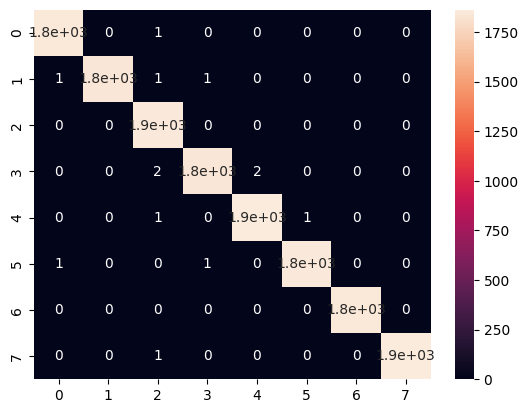

In [23]:
sns.heatmap(matrix_resnet, annot=True)

In [ ]:
matrix_crnn, acc_total_crnn, acc_per_class_crnn = calculate_confusion_matrix(
    model_crnn, train_dataset_8cls, n_classes=8, verbose=False,
)

In [19]:
# 1 min 30 s
matrix_vit_base, acc_total_vit_base, acc_per_class_vit_base = calculate_confusion_matrix(
    vit_base, train_dataset_2cls, n_classes=2, verbose=False,
)

# Silence and Unknown detection